# Running 

Tenemos un dataset en el cual tenemos datos reales de un corredor. Si bien hay muchas columnas con datos, las más relevantes son la distancia recorrida, el tiempo que se tardó, la frecuencia cardíaca y las calorías quemadas.  Para poder saber el estado de un corredor o para poder planificar de mejor manera una práctica podría ser de interés saber cómo se relaciona el tiempo que tarda el corredor en recorrer una distancia con la distancia misma o aproximadamente cuántas calorías se queman a medida que se aumenta la distancia corrida. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

In [ ]:
df = pd.read_csv("activity_log.csv",sep=",")
df.head()

Como hay filas en las cuales el valor de calorías no fue tomado (aparece como --) voy a limpiar esos valores. De paso, convierto las columnas numéricas a _integers_.  

In [3]:
print(df["Activity Type"].unique())
print(df[df["Calories"]=="--"])

['Running' 'Cardio' 'Treadmill Running']
    Activity Type            Date              Title  Distance Calories  \
154       Running    5/3/19 10:22            Running      6.21       --   
175       Running   4/20/19 20:10            Running      0.93       --   
182       Running   4/17/19 15:47            Running      9.00       --   
183       Running   4/16/19 15:45            Running      9.00       --   
186       Running   4/13/19 21:28            Running      6.20       --   
218       Running   3/29/19 22:20            Running      3.10       --   
235       Running   3/18/19 10:22            Running      1.55       --   
242       Running   3/14/19 14:10            Running      2.60       --   
268       Running   2/26/19 22:57            Running      2.25       --   
273       Running   2/23/19 20:22            Running      3.10       --   
299       Running    2/8/19 17:51            Running      3.10       --   
325       Running   1/25/19 21:55            Running      3

In [4]:
def parse_time_string(s):
    try:
        s = s.strip()
        parts = s.split(':')
        if len(parts) == 3:
            # HH:MM:SS(.fff)
            return pd.to_timedelta(s)
        elif len(parts) == 2:
            # MM:SS(.fff) → lo pasamos como '00:MM:SS(.fff)'
            return pd.to_timedelta(f"0:{s}")
        else:
            return pd.NaT
    except Exception:
        return pd.NaT
    
def lineal(x,m,b):
    return m*x + b

In [ ]:
#Paso los tiempos a segundos 
df["Time_parsed"] = df["Time"].apply(parse_time_string)
df["Time_seconds"] = df["Time_parsed"].dt.total_seconds()
df["Avg Pace_parsed"] = df["Avg Pace"].apply(parse_time_string)
df["Avg Pace_seconds"] = df["Avg Pace_parsed"].dt.total_seconds()

#Limpio la columna de calorias que tiene entradas -- o entradas escritas como 1,310 (1310)
calories_bool = df["Calories"] != "--"
df["Calories"] = df["Calories"]*calories_bool 
df["Calories"] = df["Calories"].replace({',': ''}, regex=True).apply(pd.to_numeric)
df["Calories"] = np.nan_to_num(df["Calories"])
df = df[df["Calories"] != 0]

#De paso convierto en integers las columnas numéricas 
avg_cadence_bool = df["Avg Run Cadence"] != "--"
df["Avg Run Cadence"] = df["Avg Run Cadence"]*avg_cadence_bool
df["Avg Run Cadence"] = df["Avg Run Cadence"].replace({',': ''}, regex=True).apply(pd.to_numeric)
df["Avg Run Cadence"] = np.nan_to_num(df["Avg Run Cadence"])
df = df[df["Avg Run Cadence"] != 0]


df["Max HR"] = df["Max HR"].astype(int)
df["Avg HR"] = df["Avg HR"].astype(int)



df["Avg Run Cadence"].astype(int)
df["Max Run Cadence"].astype(int)
df["Avg Stride Length"].astype(float)

Como mencioné al principio, voy a ver qué relación tiene el tiempo que tardó en correr una distancia con la distancia misma y a su vez la cantidad de calorías quemadas con la distancia recorrida. Para la primer relación, lo primero que se me ocurre es que tiene que haber una relación de proporcionalidad, si corro más distancia entonces de manera proporcional voy a tardar más. Lo que se está asumiendo al pensar esto es que el corredor va a correr siempre con la misma velocidad, o equivalentemente decir que *nunca se cansa*. Para la segunda relación podría pensar que también hay una relación de proporcionalidad, es razonable pensar que voy a quemar más calorías mientras más distancia corra.  

Por cada milla adicional que corrió el sujeto tardó 6.931167409142289 minutos más
Por cada milla adicional que corrió el sujeto quemó 73 caloría más


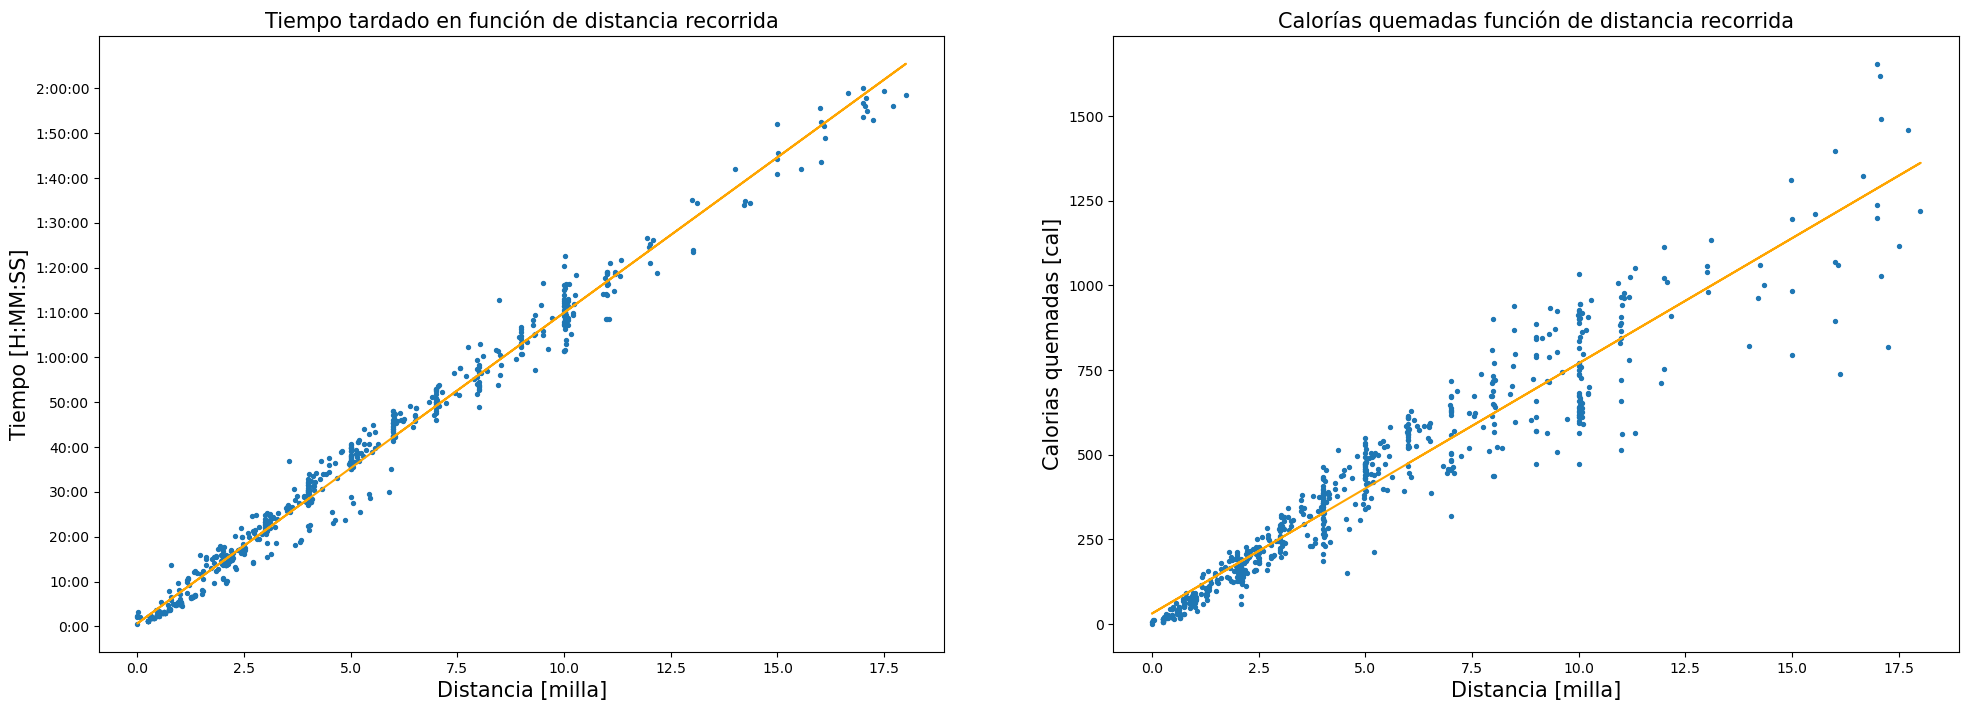

In [113]:
popt_0,pcov_0 = curve_fit(lineal,df["Distance"],df["Time_seconds"]) 
popt_1,pcov_1 = curve_fit(lineal,df["Distance"],df["Calories"]) 


fig,ax = plt.subplots(1,2,figsize=(24,8))

ax[0].set_yticks(np.arange(0,7201,600),["0:00","10:00","20:00","30:00","40:00","50:00","1:00:00","1:10:00","1:20:00","1:30:00","1:40:00","1:50:00","2:00:00"])
ax[0].scatter(df["Distance"],df["Time_seconds"],s=8)
ax[0].plot(df["Distance"],lineal(df["Distance"],*popt_0),color="orange",label= "")
ax[0].set_xlabel("Distancia [milla]",fontsize="15")
ax[0].set_ylabel("Tiempo [H:MM:SS]",fontsize="15")
ax[0].set_title("Tiempo tardado en función de distancia recorrida",fontsize="15")


ax[1].scatter(df["Distance"],df["Calories"],s=8)
ax[1].plot(df["Distance"],lineal(df["Distance"],*popt_1),color="orange",label= "")
ax[1].set_xlabel("Distancia [milla]",fontsize="15")
ax[1].set_ylabel("Calorias quemadas [cal]",fontsize="15")
ax[1].set_title("Calorías quemadas función de distancia recorrida",fontsize="15")

print("Por cada milla adicional que corrió el sujeto tardó " + str(float(popt_0[0]/60)) + " minutos más")
print("Por cada milla adicional que corrió el sujeto quemó " + str(int(popt_1[0])) + " caloría más")

Como se puede observar en las figuras de arriba, ambas relaciones pareciera que son lineales. Es de notar que hay partes de los gráficos en los cuales para la misma distancia hay varias entradas, esto es porque el corredor corrió esa distancia varias veces y tardó más o menos tiempo y quemó más o menos calorías. Esto parece indicarnos algo muy importante: El tiempo que se tarda en recorrer una distancia no depende sólo de la distancia en sí y lo mismo para las calorías quemadas, ya que tenemos distintos valores para mismas distancias. Veamos qué pasa si fijamos una distancia. 

Para la relación entre tiempo y distancia ya sé que el tiempo que tarde va a ser proporcional al ritmo ya que el ritmo está definido de esa manera (tiempo tardado/distancia recorrida), por lo que sé que el gráfico va a ser una lineal. 

Por cada segundo adicional de ritmo el sujeto tardó 10 segundos más
Por cada BPM más de frecuencia cardíaca promedio el sujeto quemó 12 caloría más


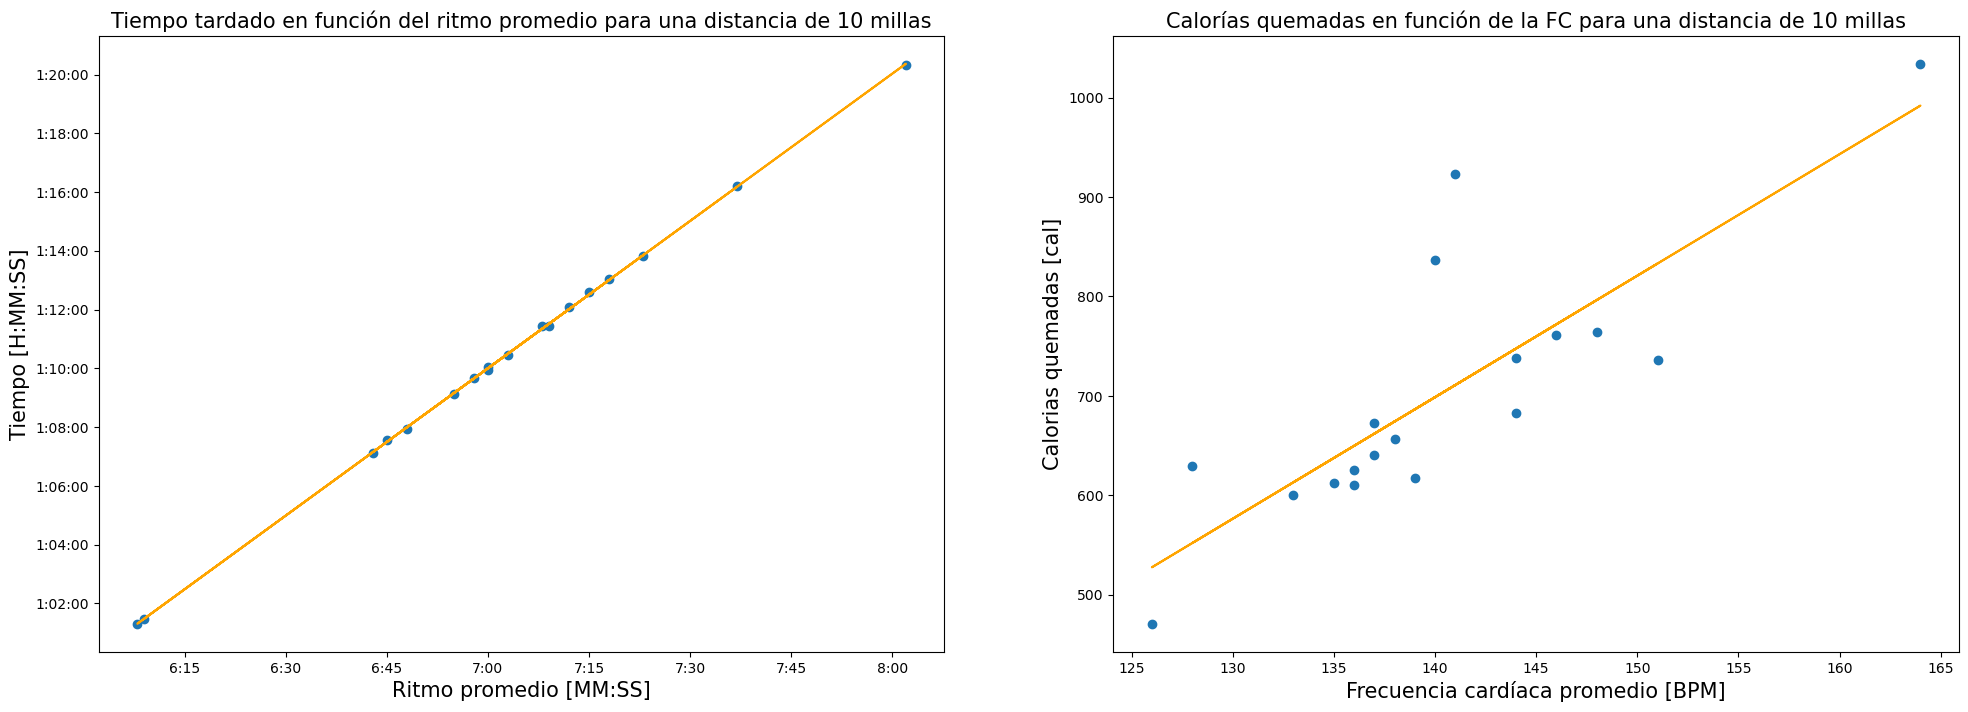

In [128]:
distancia_fija = 10
popt_2,pcov_2 = curve_fit(lineal,df[df["Distance"]==distancia_fija]["Avg Pace_seconds"],df[df["Distance"]==distancia_fija]["Time_seconds"]) 
popt_3,pcov_3 = curve_fit(lineal,df[df["Distance"]==distancia_fija]["Avg HR"],df[df["Distance"]==distancia_fija]["Calories"]) 

fig, ax = plt.subplots(1,2,figsize=(24,8))

#Las top 5 distancias repetidas son: 4,5,10,6,10.01 



ax[0].set_yticks(np.arange(3600,4801,120),["1:00:00","1:02:00","1:04:00","1:06:00","1:08:00","1:10:00","1:12:00","1:14:00","1:16:00","1:18:00","1:20:00"])
ax[0].set_xticks(np.arange(360,481,15),["6:00","6:15","6:30","6:45","7:00","7:15","7:30","7:45","8:00"])
ax[0].scatter(df[df["Distance"]==distancia_fija]["Avg Pace_seconds"],df[df["Distance"]==distancia_fija]["Time_seconds"])
ax[0].plot(df[df["Distance"]==distancia_fija]["Avg Pace_seconds"],lineal(df[df["Distance"]==distancia_fija]["Avg Pace_seconds"],*popt_2),color="orange")
ax[0].set_xlabel("Ritmo promedio [MM:SS]",fontsize=15)
ax[0].set_ylabel("Tiempo [H:MM:SS]",fontsize=15)
ax[0].set_title("Tiempo tardado en función del ritmo promedio para una distancia de %s millas"%distancia_fija,fontsize=15)

ax[1].scatter(df[df["Distance"]==distancia_fija]["Avg HR"],df[df["Distance"]==distancia_fija]["Calories"])
ax[1].plot(df[df["Distance"]==distancia_fija]["Avg HR"],lineal(df[df["Distance"]==distancia_fija]["Avg HR"],*popt_3),color="orange")
ax[1].set_xlabel("Frecuencia cardíaca promedio [BPM]",fontsize=15)
ax[1].set_ylabel("Calorias quemadas [cal]",fontsize=15)
ax[1].set_title("Calorías quemadas en función de la FC para una distancia de %s millas"%distancia_fija,fontsize=15)
print("Por cada segundo adicional de ritmo el sujeto tardó " + str(int(popt_2[0])) + " segundos más")
print("Por cada BPM más de frecuencia cardíaca promedio el sujeto quemó " + str(int(popt_3[0])) + " caloría más")

Como era de esperarse, la relación entre el tiempo que tardó y el ritmo promedio es perfectamente lineal, mientras que la relación entre las calorías quemadas y la frecuencia cardíaca promedio no es tan clara. 
Yo al ser una persona que recién arranca a correr tengo millones de cosas para arreglar en cuanto a la técnica. Una de las tantas preguntas que tengo es qué tan rápido tengo que pisar y qué tan largos tienen que ser mis pasos. La cadencia y la longitud de paso son dos parámetros que describen esta información que yo quiero, por lo que voy a tratar de ver es si suele mantener una cadencia/longitud de paso constante y si no es el caso entonces dependiendo de qué otro valor los varía. 

Text(0, 0.5, 'Cantidad de ocurrencias')

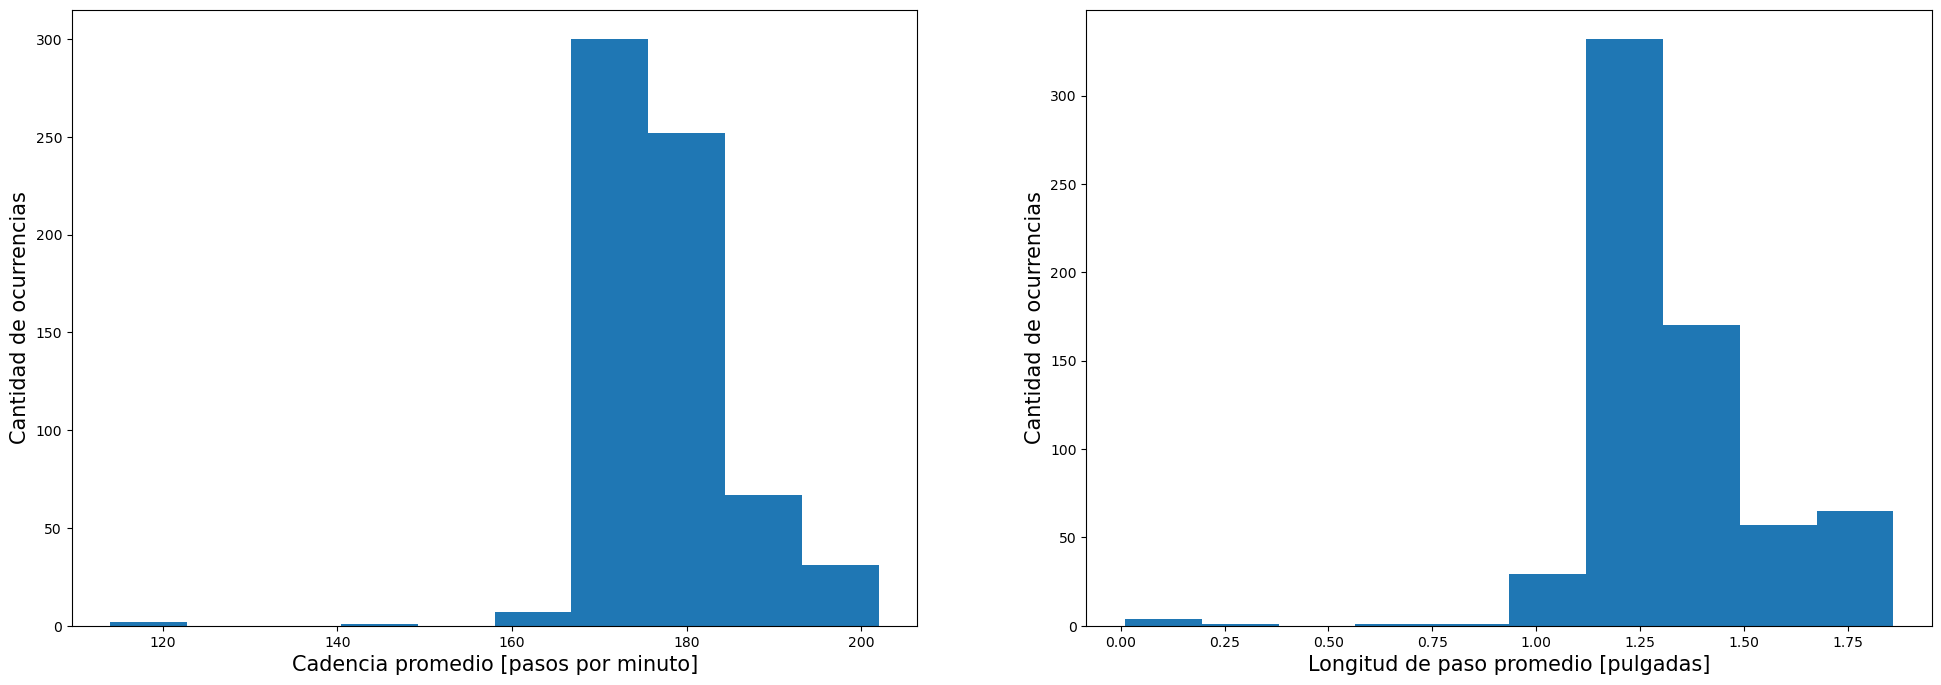

In [155]:
fig, ax = plt.subplots(1,2,figsize=(24,8))

ax[0].hist(df["Avg Run Cadence"])
ax[0].set_xlabel("Cadencia promedio [pasos por minuto]",fontsize=15)
ax[0].set_ylabel("Cantidad de ocurrencias",fontsize=15)


ax[1].hist(df["Avg Stride Length"])
ax[1].set_xlabel("Longitud de paso promedio [pulgadas]",fontsize=15)
ax[1].set_ylabel("Cantidad de ocurrencias",fontsize=15)

In [156]:
np.mean(df["Avg Run Cadence"]),np.mean(df["Avg Stride Length"])

(177.0090909090909, 1.3336060606060605)

A simple vista se puede observar que el corredor suele correr con una cadencia y longitud de paso constante: 177 pasos por minuto y 1.33 pulgadas. Algo que se me ocurre es que para distancias más largas el corredor varíe su cadencia y longitud de pasos, capaz hace que ambas valgan un valor tal que la energía que gaste por pisada sea la menor posible. 

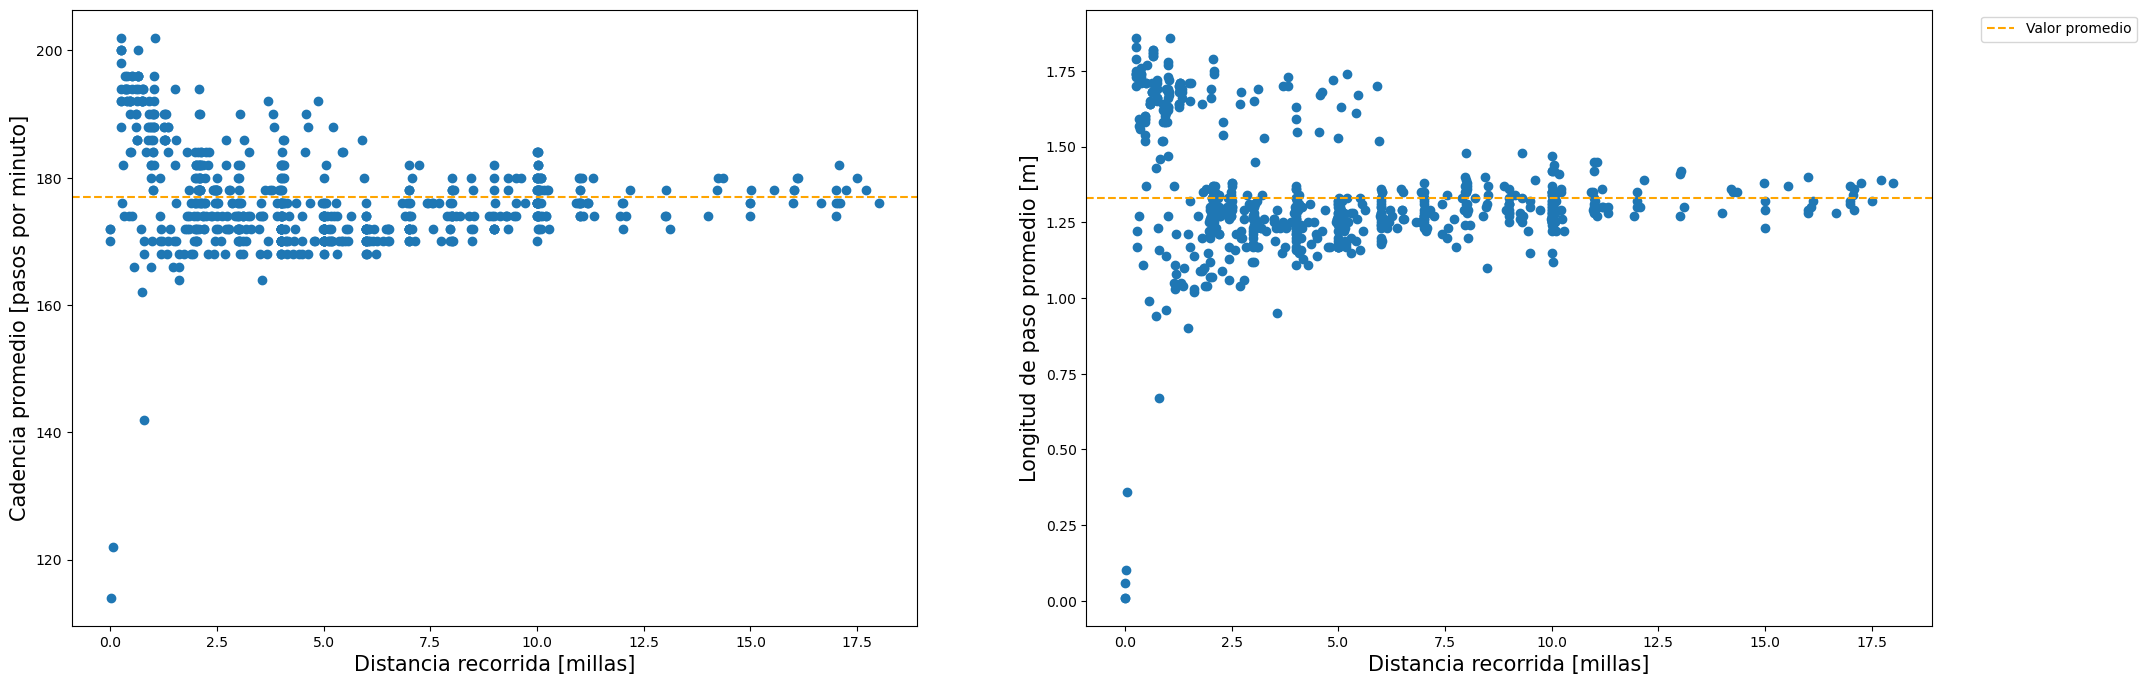

In [168]:
fig, ax = plt.subplots(1,2,figsize=(24,8))

ax[0].scatter(df["Distance"],df["Avg Run Cadence"])
ax[0].axhline(177,ls="--",color="orange",label="Valor promedio")
ax[0].set_xlabel("Distancia recorrida [millas]",fontsize=15)
ax[0].set_ylabel("Cadencia promedio [pasos por minuto]",fontsize=15)


ax[1].scatter(df["Distance"],df["Avg Stride Length"])
ax[1].axhline(1.33,ls="--",color="orange",label="Valor promedio")
ax[1].set_xlabel("Distancia recorrida [millas]",fontsize=15)
ax[1].set_ylabel("Longitud de paso promedio [m]",fontsize=15)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Como se puede observar, masomenos la cadencia y la longitud de paso es constante sin importar qué distancia se recorra. Como sucedía antes, hay varios valores para la misma distancia y es porque el corredor realizó esa distancia varias veces. Aprovechemos eso y fijemos el valor de la distancia recorrida, y veamos si la cadencia/longitud de paso depende de otro factor como podría ser el ritmo. 

Text(0.5, 1.0, 'Longitud de paso promedio en función del ritmo promedio para una distancia de 5 millas')

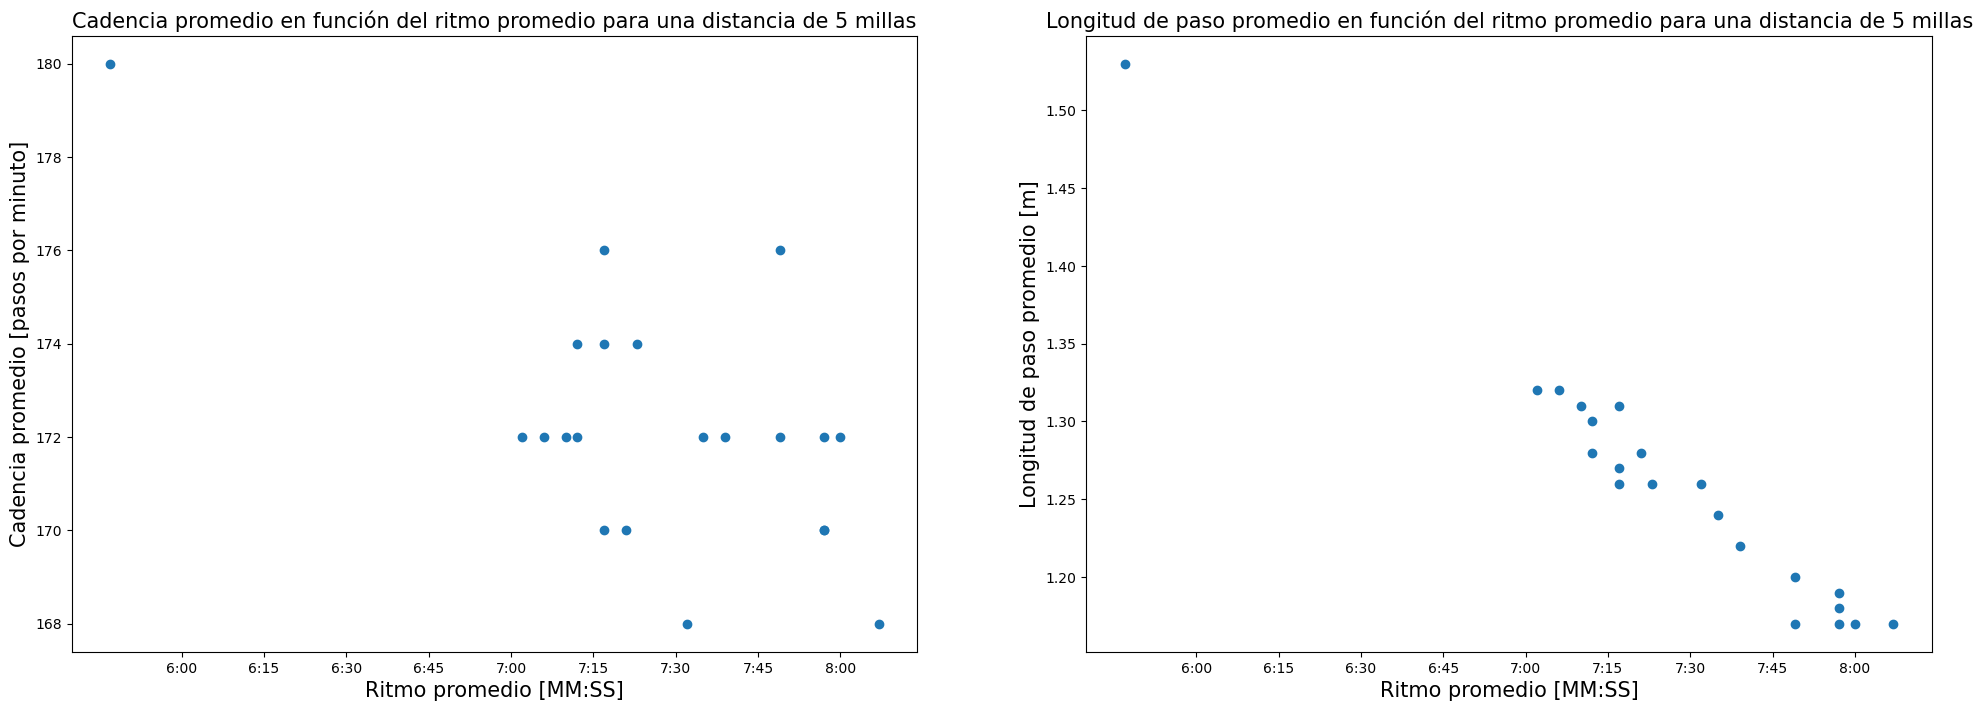

In [175]:
distancia_fija = 5
#popt_2,pcov_2 = curve_fit(lineal,df[df["Distance"]==distancia_fija]["Avg Pace_seconds"],df[df["Distance"]==distancia_fija]["Time_seconds"]) 
#popt_3,pcov_3 = curve_fit(lineal,df[df["Distance"]==distancia_fija]["Avg HR"],df[df["Distance"]==distancia_fija]["Calories"]) 

fig, ax = plt.subplots(1,2,figsize=(24,8))

#Las top 5 distancias repetidas son: 4,5,10,6,10.01 



ax[0].set_xticks(np.arange(360,481,15),["6:00","6:15","6:30","6:45","7:00","7:15","7:30","7:45","8:00"])
ax[0].scatter(df[df["Distance"]==distancia_fija]["Avg Pace_seconds"],df[df["Distance"]==distancia_fija]["Avg Run Cadence"])
#ax[0].plot(df[df["Distance"]==distancia_fija]["Avg Pace_seconds"],lineal(df[df["Distance"]==distancia_fija]["Avg Pace_seconds"],*popt_2),color="orange")
ax[0].set_xlabel("Ritmo promedio [MM:SS]",fontsize=15)
ax[0].set_ylabel("Cadencia promedio [pasos por minuto]",fontsize=15)
ax[0].set_title("Cadencia promedio en función del ritmo promedio para una distancia de %s millas"%distancia_fija,fontsize=15)


ax[1].set_xticks(np.arange(360,481,15),["6:00","6:15","6:30","6:45","7:00","7:15","7:30","7:45","8:00"])
ax[1].scatter(df[df["Distance"]==distancia_fija]["Avg Pace_seconds"],df[df["Distance"]==distancia_fija]["Avg Stride Length"])
#ax[1].plot(df[df["Distance"]==distancia_fija]["Avg HR"],lineal(df[df["Distance"]==distancia_fija]["Avg HR"],*popt_3),color="orange")
ax[1].set_xlabel("Ritmo promedio [MM:SS]",fontsize=15)
ax[1].set_ylabel("Longitud de paso promedio [m]",fontsize=15)
ax[1].set_title("Longitud de paso promedio en función del ritmo promedio para una distancia de %s millas"%distancia_fija,fontsize=15)




#print("Por cada segundo adicional de ritmo el sujeto tardó " + str(int(popt_2[0])) + " segundos más")
#print("Por cada BPM más de frecuencia cardíaca promedio el sujeto quemó " + str(int(popt_3[0])) + " caloría más")

Como se puede observar arriba, pareciera que para una distancia fija no se ve una relación clara entre la cadencia promedio con el ritmo promedio aunque pareciera que a mayor ritmo menor es la cadencia promedio. Por otra parte, hay una relación clara entre la longitud de paso y el ritmo: a menor ritmo la longitud de paso es menor.  

Entonces, concluyo que para hay una relación proporcional entre las calorías que se queman con la distancia que se recorre y que la cadencia/longitud de paso se mantienen masomenos constantes para las distancias entre 0.1 a 17.5 millas. Por otra parte, si quiero bajar el ritmo con el que corro tengo que agrandar la longitud de mis pasos. Si bien esto es una sobre simplificación de lo que es correr, pude sacar algunos _insights_ valiosos para mis próximas prácticas. 